In [1]:
# 0.1

import cv2
import numpy as np

# Create ArUco dictionary and detector parameters (4x4 tags)
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
aruco_params = cv2.aruco.DetectorParameters()
detector = cv2.aruco.ArucoDetector(aruco_dict, aruco_params)

image_corners = []
world_coords = []
aruco_tag_size = 0.06
obj_points_single = np.array([
        [0, 0, 0],
        [aruco_tag_size, 0, 0],
        [aruco_tag_size, aruco_tag_size, 0],
        [0, aruco_tag_size, 0]
    ], dtype=np.float32)

counter = 1
img_size = None
for i in range(32):
    image = cv2.imread(f"aruco_tags/{counter}.jpg")
    counter += 1
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if img_size is None:
        img_size = gray_image.shape[::-1]
    corners, ids, _ = detector.detectMarkers(gray_image)
    if ids is not None:
        # process
        for i, tag_id in enumerate(ids):
            image_corners.append(corners[i].reshape(4, 2).astype(np.float32))
            world_coords.append(obj_points_single)
    else:
        pass

ret, camera_matrix, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(world_coords, image_corners, img_size, None, None)

print(camera_matrix, dist_coeffs, rvecs, tvecs)

[[3.55775689e+03 0.00000000e+00 1.61285252e+03]
 [0.00000000e+00 3.47118648e+03 2.14338148e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] [[ 0.43561192 -4.36319127  0.03074344  0.02855933 13.13426002]] (array([[-0.08518049],
       [ 1.03067968],
       [ 2.90504149]]), array([[-0.06999489],
       [ 1.02832138],
       [ 2.90812811]]), array([[-0.11662191],
       [ 0.99994012],
       [ 2.91990601]]), array([[-0.08244668],
       [ 0.97317923],
       [ 2.92500012]]), array([[-0.13153394],
       [ 0.93552899],
       [ 2.93505401]]), array([[-0.08975283],
       [ 0.92736514],
       [ 2.936545  ]]), array([[-0.04839125],
       [-1.07450175],
       [-2.89223986]]), array([[-0.02245598],
       [-1.080881  ],
       [-2.89249805]]), array([[-0.03847117],
       [-1.02347696],
       [-2.91533   ]]), array([[-0.00355066],
       [-1.04130064],
       [-2.90315034]]), array([[-0.03823304],
       [-0.97720962],
       [-2.93519795]]), array([[-7.07173095e-04],
       [-9.88921

In [3]:
# 0.3

def estimate_camera(cameraMatrix, distCoeffs):
    # Create ArUco dictionary and detector parameters (4x4 tags)
    aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
    aruco_params = cv2.aruco.DetectorParameters()
    detector = cv2.aruco.ArucoDetector(aruco_dict, aruco_params)

    aruco_tag_size = 0.06
    obj_points_single = np.array([
            [0, 0, 0],
            [aruco_tag_size, 0, 0],
            [aruco_tag_size, aruco_tag_size, 0],
            [0, aruco_tag_size, 0]
        ], dtype=np.float32)
    matrices = []
    images = []

    counter = 1
    for i in range(30):
        image = cv2.imread(f"purse_aruco/{counter}.jpg")
        if image is None:
            print("could not read image")
            counter += 1
            continue
        counter += 1
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        corners, ids, _ = detector.detectMarkers(gray_image)
        if ids is not None and len(ids) == 1:
            image_points = corners[0].reshape(4, 2).astype(np.float32)
            success, rvec, tvec = cv2.solvePnP(
                obj_points_single,
                image_points,
                cameraMatrix,
                distCoeffs
            )
            if success:
                R, _ = cv2.Rodrigues(rvec)
                matrices.append(np.hstack([R.T, -R.T @ tvec]))
                images.append(image)
        else:
            pass
    return matrices, images

In [ ]:
import viser
import time

matrices, images = estimate_camera(camera_matrix, dist_coeffs)
server = viser.ViserServer(share=True)
server.scene.reset()

# Add all cameras
for i, (c2w, image) in enumerate(zip(matrices, images)):
    H, W = image.shape[:2]
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    server.scene.add_camera_frustum(
        f"/cameras/{i}",
        fov=2 * np.arctan2(H / 2, camera_matrix[0, 0]),
        aspect=W / H,
        scale=0.05,
        wxyz=viser.transforms.SO3.from_matrix(c2w[:3, :3]).wxyz,
        position=c2w[:3, 3],
        image=rgb
    )

╭────── viser (listening *:8080) ───────╮
│             ╷                         │
│   HTTP      │ http://localhost:8080   │
│   Websocket │ ws://localhost:8080     │
│             ╵                         │
╰───────────────────────────────────────╯

(viser) Share URL requested!

(viser) Generated share URL (expires in 24 hours, max 16 clients): https://mega-viewport.share.viser.studio

opening handshake failed
Traceback (most recent call last):
  File "/Users/aditimundra/miniconda3/lib/python3.12/site-packages/websockets/http11.py", line 138, in parse
    request_line = yield from parse_line(read_line)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/aditimundra/miniconda3/lib/python3.12/site-packages/websockets/http11.py", line 309, in parse_line
    line = yield from read_line(MAX_LINE_LENGTH)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/aditimundra/miniconda3/lib/python3.12/site-packages/websockets/streams.py", line 46, in read_line
    raise EOFError(f"stream ends after {p} bytes, before end of line")
EOFError: stream ends after 0 bytes, before end of line

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/aditimundra/miniconda3/lib/python3.12/site-packages/websockets/server.py", line 545, in parse
    request = yield from Request.parse(
              ^^^^^^

In [64]:
# 0.4

def create_dataset(images, camera_matrix, dist_coeffs):
    undistorted_images = []
    for i, img in enumerate(images):
        undist = cv2.undistort(img, camera_matrix, dist_coeffs)
        undistorted_images.append(undist)
    undistorted_images = np.array(undistorted_images)

    c2ws = []
    for c2w_3x4 in matrices:
        fixed = np.vstack([c2w_3x4, [0, 0, 0, 1]])
        c2ws.append(fixed)
    c2ws = np.array(c2ws)
    focal = float(camera_matrix[0, 0])

    n_total = len(undistorted_images)
    n_train = int(n_total * 1)
    n_val = int(n_total * 0)
    n_test = n_total - n_train - n_val
    indices = np.arange(n_total)
    np.random.seed(180)
    np.random.shuffle(indices)
    
    train_indices = indices[:n_train]
    val_indices = indices[n_train:n_train + n_val]
    test_indices = indices[n_train + n_val:]
    images_train = undistorted_images[train_indices]
    c2ws_train = c2ws[train_indices]
    images_val = undistorted_images[val_indices]
    c2ws_val = c2ws[val_indices]
    c2ws_test = c2ws[test_indices]
    np.savez(
        "dataset.npz",
        images_train=images_train,   
        c2ws_train=c2ws_train,        
        images_val=images_val,   
        c2ws_val=c2ws_val, 
        c2ws_test=c2ws_test, 
        focal=focal 
    )

    return images_train, images_val, c2ws_train, c2ws_val, c2ws_test, focal

In [65]:
create_dataset(images, camera_matrix, dist_coeffs)

(array([[[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
 
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
 
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
 
         ...,
 
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
 
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
 
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]],
 
 
        [[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0

In [6]:
# 1.1

import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class NeuralField2D(nn.Module):
    def __init__(self, hidden_dim=256):
        super(NeuralField2D, self).__init__()
        self.pe = PositionalEncoding(L=10)
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(42, hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, 3))
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, coords):
        x = self.pe(coords)
        for i in range(len(self.layers) - 1):
            x = self.layers[i](x)
            x = self.relu(x)
        x = self.layers[-1](x)
        return self.sigmoid(x)
    
class PositionalEncoding(nn.Module):
    def __init__(self, L=10):
        super(PositionalEncoding, self).__init__()
        self.L = L
    def forward(self, x):
        position = [x]
        for i in range(self.L):
            value = 2**i * torch.pi
            position.append(torch.sin(value * x))
            position.append(torch.cos(x * value))
        return torch.cat(position, dim=-1)
    
class ImageDataLoader(Dataset):
    def __init__(self, image_path, target_size=(256, 256)):
        image = Image.open(image_path).convert('RGB')
        # image = image.resize(target_size)
        image_norm = np.array(image).astype(np.float32) / 255.0
        self.H, self.W = image_norm.shape[:2]

        y_coords, x_coords = np.meshgrid(np.linspace(0, 1, self.H), np.linspace(0, 1, self.W), indexing='ij')
        self.coords = np.stack([x_coords.flatten(), y_coords.flatten()], axis=-1)
        self.colors = image_norm.reshape(-1, 3)
        self.image = image

    def __len__(self):
        return len(self.coords)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.coords[idx]).float(), torch.from_numpy(self.colors[idx]).float()

def train_nerf(model, dataloader, dataset, num_iters=3000, lr=1e-2, device='cpu', log_intervals=[100, 500, 1000, 2000, 3000]):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    psnr_history = []
    image_snaps = {}
    coords = torch.from_numpy(dataset.coords).float().to(device)
    colors = torch.from_numpy(dataset.colors).float().to(device)

    iteration = 0
    while iteration < num_iters:
        for batch_coords, batch_colors in dataloader:
            batch_coords = batch_coords.to(device)
            batch_colors = batch_colors.to(device)
            model.train()
            pred_colors = model(batch_coords)
            loss = criterion(pred_colors, batch_colors)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if iteration % 10 == 0 or iteration == num_iters - 1:
                model.eval()
                with torch.no_grad():
                    pred_colors = model(coords)
                    mse = criterion(pred_colors, colors)
                    psnr_history.append((iteration, psnr(mse).item()))
                    if iteration in log_intervals:
                        pred_image = pred_colors.cpu().reshape(dataset.H, dataset.W, 3).numpy()
                        image_snaps[iteration] = pred_image
            
            iteration += 1
    return psnr_history, image_snaps

def psnr(mse):
    return 10 * torch.log10(1.0 / mse)

In [ ]:
import matplotlib.pyplot as plt

def visualize_results(model, dataset, device='cpu'):
    model.eval()
    model = model.to(device)
    
    with torch.no_grad():
        coords = torch.from_numpy(dataset.coords).float().to(device)
        pred_colors = model(coords)
        pred_image = pred_colors.cpu().reshape(dataset.H, dataset.W, 3).numpy()
    
    _, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    axes[0].imshow(dataset.image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    axes[1].imshow(pred_image)
    axes[1].set_title("Reconstruction")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.savefig('neural_field_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    mse = np.mean((dataset.image - pred_image) ** 2)
    psnr = psnr(mse)
    print(f"\nFinal PSNR: {psnr:.2f} dB")

def plot_psnr_curve(image_path):    
    dataset = ImageDataLoader(image_path, target_size=(256, 256))
    dataloader = DataLoader(dataset, batch_size=10000, shuffle=True)
    model = NeuralField2D(hidden_dim=256)
    
    psnr_history, _ = train_nerf(
        model, dataloader, dataset
    )
    
    iterations, psnrs = zip(*psnr_history)
    
    plt.figure(figsize=(10, 6))
    plt.plot(iterations, psnrs, linewidth=2)
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('PSNR (dB)', fontsize=12)
    plt.title(f'Training PSNR Curve\nFinal PSNR: {psnrs[-1]:.2f} dB', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('psnr_curve.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Final PSNR: {psnrs[-1]:.2f} dB")

def show_training_progression(dataset1_path, dataset2_path):    
    fig, axes = plt.subplots(2, 6, figsize=(18, 6))
    
    for row, img_path in enumerate([dataset1_path, dataset2_path]):
        dataset = ImageDataLoader(img_path)
        dataloader = DataLoader(dataset, batch_size=10000, shuffle=True)
        model = NeuralField2D(hidden_dim=256)
        
        _, snapshots = train_nerf(
            model, dataloader, dataset
        )
        
        axes[row, 0].imshow(dataset.image)
        axes[row, 0].set_title('Original')
        axes[row, 0].axis('off')
        
        for col, (iter_num, img) in enumerate(sorted(snapshots.items()), start=1):
            axes[row, col].imshow(img)
            axes[row, col].set_title(f'Iter {iter_num}')
            axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.savefig('training_progression.png', dpi=150, bbox_inches='tight')
    plt.show()

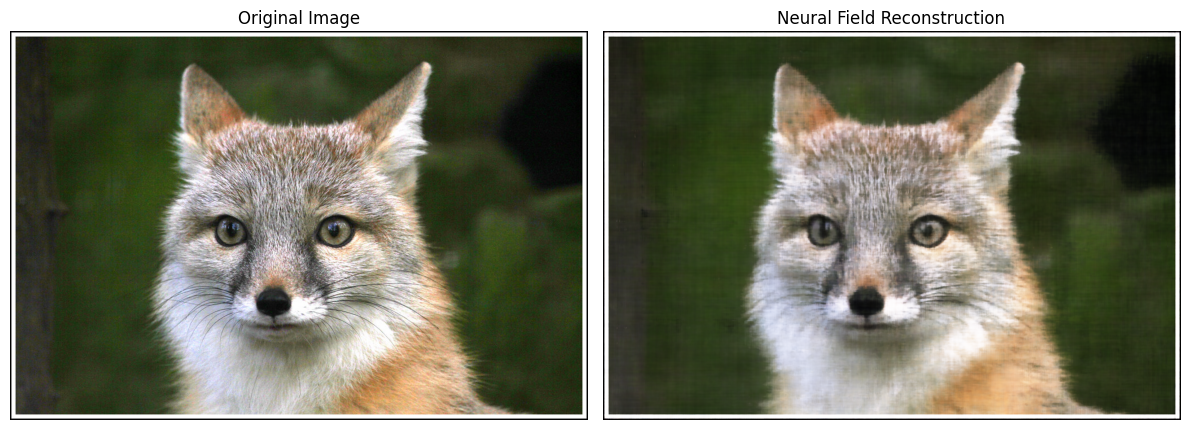


Final PSNR: -41.51 dB
NeuralField2D(
  (pe): PositionalEncoding()
  (layers): ModuleList(
    (0): Linear(in_features=42, out_features=256, bias=True)
    (1-2): 2 x Linear(in_features=256, out_features=256, bias=True)
    (3): Linear(in_features=256, out_features=3, bias=True)
  )
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [ ]:
image_path = "fox.jpg"
dataset = ImageDataLoader(image_path)
dataloader = DataLoader(dataset, batch_size=10000, shuffle=True)
model = NeuralField2D()
train_nerf(model, dataloader, dataset)
visualize_results(model, dataset)
print(model)


Training to generate PSNR curve...


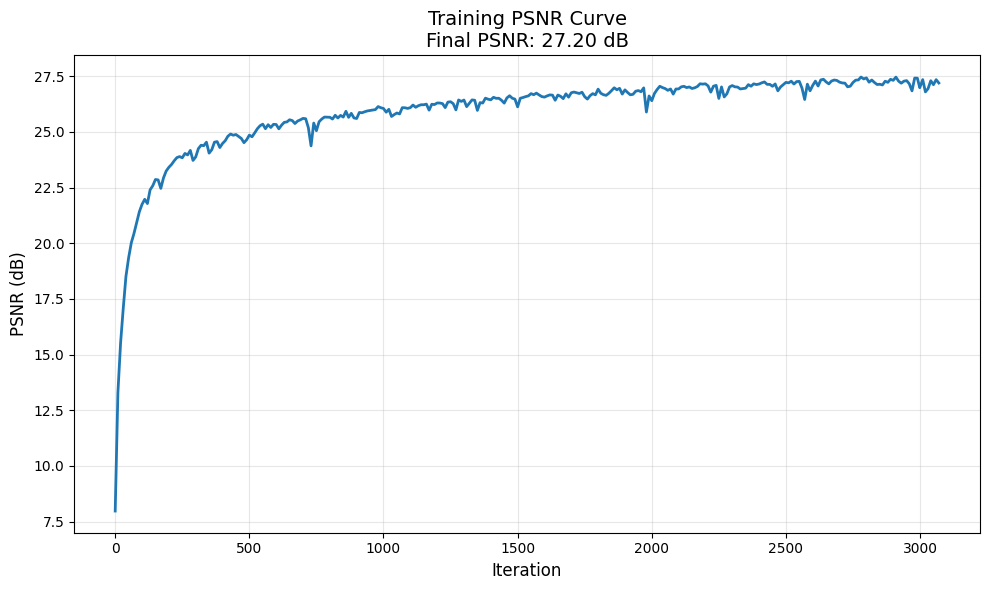


Saved: psnr_curve.png
Final PSNR: 27.20 dB


In [ ]:
plot_psnr_curve("face.jpg")

In [ ]:
def hyperparameter_grid(image_path, L_values=[2, 10], hidden_dims=[64, 256], 
                       num_iterations=3000):    
    _, axes = plt.subplots(2, 2, figsize=(12, 12))
    dataset = ImageDataLoader(image_path, target_size=(256, 256))
    dataloader = DataLoader(dataset, batch_size=10000, shuffle=True)
    model = NeuralField2D(hidden_dim=256)
    configurations = [
        (L_values[0], hidden_dims[0]), 
        (L_values[0], hidden_dims[1]), 
        (L_values[1], hidden_dims[0]), 
        (L_values[1], hidden_dims[1]), 
    ] 
    results = []
    for idx, (L, width) in enumerate(configurations):
        row = idx // 2
        col = idx % 2
        model = NeuralField2D(hidden_dim=width)
        num_params = sum(p.numel() for p in model.parameters())
        psnr_history, snapshots = train_nerf(
            model, dataloader, dataset
        )
        final_image = snapshots[num_iterations]
        final_psnr = psnr_history[-1][1]
        axes[row, col].imshow(final_image)
        axes[row, col].set_title(f'L={L}, Width={width}\nPSNR={final_psnr:.2f} dB\nParams={num_params:,}')
        axes[row, col].axis('off')
        results.append({
            'L': L,
            'width': width,
            'params': num_params,
            'psnr': final_psnr
        }) 
    plt.tight_layout()
    plt.savefig('hyperparameter_grid.png', dpi=150, bbox_inches='tight')
    plt.show()



Configuration 1: L=2, Width=64

Configuration 2: L=2, Width=256

Configuration 3: L=10, Width=64

Configuration 4: L=10, Width=256


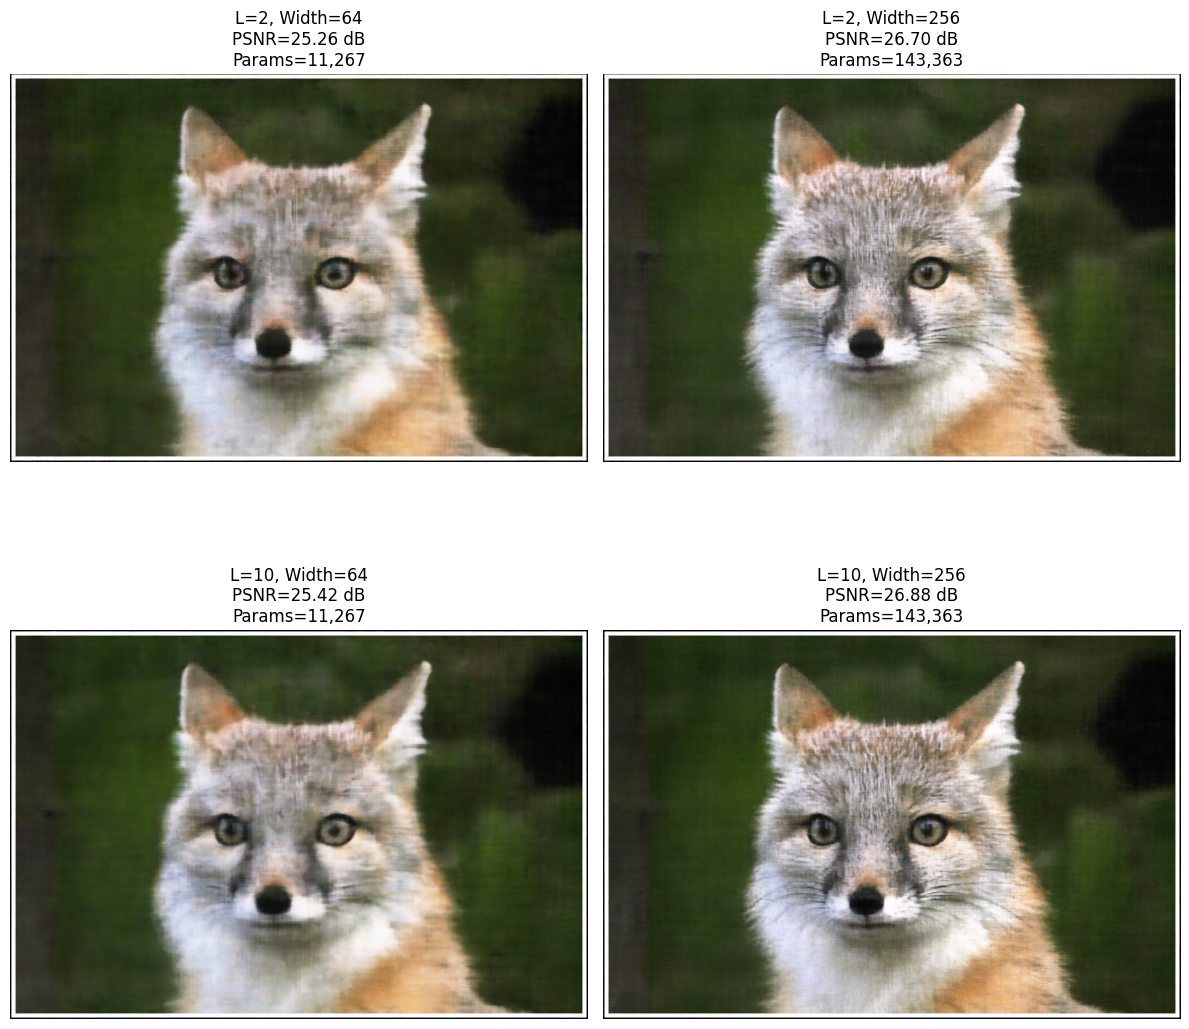


Saved: hyperparameter_grid.png

HYPERPARAMETER COMPARISON
L     Width      Params       PSNR (dB) 
------------------------------------------------------------
2     64         11,267       25.26     
2     256        143,363      26.70     
10    64         11,267       25.42     
10    256        143,363      26.88     


In [ ]:
hyperparameter_grid("fox.jpg")

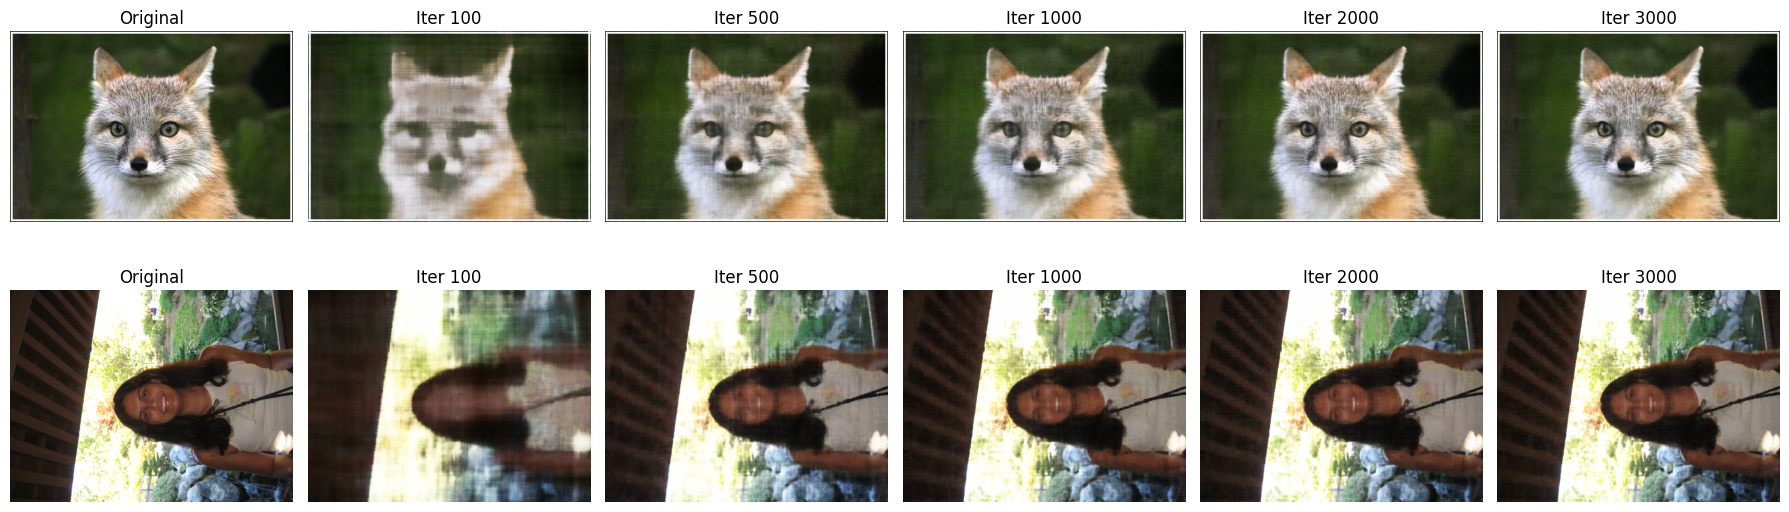


Saved: training_progression.png


In [ ]:
show_training_progression("fox.jpg", "face.jpg")

In [7]:
# 2.1

def transform(c2w, x_c):
    if x_c.ndim == 1:
        x_c = torch.cat([x_c, torch.ones(1, device=x_c.device)])
        result = c2w @ x_c
        return result[:3] / result[3]
    else:
        ones = torch.ones((x_c.shape[0], 1), device=x_c.device)
        x_c = torch.cat([x_c, ones], dim=1)
        result = (c2w @ x_c.T).T
        return result[:, :3] / result[:, 3:4]
    
def pixel_to_camera(K, uv, s):
    K_inv = torch.linalg.inv(K)
    if uv.ndim == 1:
        uv = torch.cat([uv, torch.ones(1, device=uv.device)])
        return s * (K_inv @ uv)
    else:
        ones = torch.ones([uv.shape[0], 1], device=uv.device)
        uv = torch.cat([uv, ones], dim=1)
        if isinstance(s, (int, float)):
            s = torch.full((uv.shape[0],), s, device=uv.device)
        s = s.reshape(-1, 1)
        x_c = s * (K_inv @ uv.T).T
        return x_c
    
def pixel_to_ray(K, c2w, uv):
    ro = c2w[:3, 3]
    s = 1.0
    x_c = pixel_to_camera(K, uv, s)
    x_w = transform(c2w, x_c)
    if x_w.ndim == 1:
        rd = x_w - ro
        rd = rd / torch.norm(rd)
    else:
        ro = ro.unsqueeze(0).expand(x_w.shape[0], -1)
        rd = x_w - ro
        rd = rd / torch.norm(rd, dim=1, keepdim=True)
    return ro, rd

In [8]:
# 2.2

def sample_rays_from_images(images, c2ws, K, n_rays, device='mps'):
    H, W = images[0].shape[:2]
    ray_count = n_rays // len(images)
    ros, rds, rgb_gt = [], [], []

    if isinstance(images, np.ndarray):
        images = torch.from_numpy(np.stack(images)).float().to(device)
    if isinstance(c2ws, np.ndarray):
        c2ws = torch.from_numpy(c2ws).float().to(device)
    if isinstance(K, np.ndarray):
        K = torch.from_numpy(K).float().to(device)

    for i in range(len(images)):
        # offset
        u = torch.rand(ray_count, device=device) * W
        v = torch.rand(ray_count, device=device) * H
        uv = torch.stack([u + 0.5, v + 0.5], dim=1)

        ro, rd = pixel_to_ray(K, c2ws[i], uv)
        ros.append(ro)
        rds.append(rd)

        u_int = u.long().clamp(0, W - 1)
        v_int = v.long().clamp(0, H - 1)
        rgb = images[i, v_int, u_int, :]
        rgb_gt.append(rgb)

    return torch.cat(ros, dim=0), torch.cat(rds, dim=0), torch.cat(rgb_gt, dim=0)

def sample_points_along_rays(ros, rds, near=2.0, far=6.0, n_samples=32, perturbation=True):
    N = ros.shape[0]
    device = ros.device
    t = torch.linspace(near, far, n_samples, device=device).expand(N, n_samples)
    if perturbation:
        t_mid = 0.5 * (t[:, :-1] + t[:, 1:])
        upper = torch.cat([t_mid, t[:, -1:]], dim=-1)
        lower = torch.cat([t[:, :1], t_mid], dim=-1)
        t = lower + (upper - lower) * torch.rand_like(lower)
    points = ros.unsqueeze(1) + rds.unsqueeze(1) * t.unsqueeze(-1)
    return points, t

In [9]:
# 2.3

class RaysData(Dataset):
    def __init__(self, images, K, c2ws, device='mps'):
        self.images = images
        self.c2ws = c2ws
        self.K = K
        self.device = device
        self.n_images, self.H, self.W = images.shape[:3]

        if isinstance(images, np.ndarray):
            self.images = torch.from_numpy(images).float().to(device)
        if isinstance(K, np.ndarray):
            self.K = torch.from_numpy(K).float().to(device)
        if isinstance(c2ws, np.ndarray):
            self.c2ws = torch.from_numpy(c2ws).float().to(device)

        all_rays_o = []
        all_rays_d = []
        all_pixels = []
        all_uvs = []
        
        for i in range(self.n_images):
            u = torch.arange(self.W, device=device).float() + 0.5
            v = torch.arange(self.H, device=device).float() + 0.5
            v_grid, u_grid = torch.meshgrid(v, u, indexing='ij')
            uv = torch.stack([u_grid.flatten(), v_grid.flatten()], dim=1)
            ray_o, ray_d = pixel_to_ray(self.K, self.c2ws[i], uv)
            pixels = self.images[i].reshape(-1, 3)
            
            all_rays_o.append(ray_o)
            all_rays_d.append(ray_d)
            all_pixels.append(pixels)
            all_uvs.append(uv)
        
        self.rays_o = torch.cat(all_rays_o, dim=0) 
        self.rays_d = torch.cat(all_rays_d, dim=0) 
        self.pixels = torch.cat(all_pixels, dim=0) 
        self.uvs = torch.cat(all_uvs, dim=0)
    
    def __len__(self):
        return len(self.rays_o)
    
    def __getitem__(self, i):
        return self.rays_o[i], self.rays_d[i], self.pixels[i]
    
    def sample_rays(self, N):
        return sample_rays_from_images(self.images, self.c2ws, self.K, N)

In [42]:
data = np.load(f"lego_200x200.npz")

# Training images: [100, 200, 200, 3]
images_train = data["images_train"] / 255.0
H, W = images_train.shape[1:3]

# Cameras for the training images 
# (camera-to-world transformation matrix): [100, 4, 4]
c2ws_train = data["c2ws_train"]

# Validation images: 
images_val = data["images_val"] / 255.0

# Cameras for the validation images: [10, 4, 4]
# (camera-to-world transformation matrix): [10, 200, 200, 3]
c2ws_val = data["c2ws_val"]

# Test cameras for novel-view video rendering: 
# (camera-to-world transformation matrix): [60, 4, 4]
c2ws_test = data["c2ws_test"]

# Camera focal length
focal = data["focal"]  # float

K = np.array([
    [focal, 0.0, (W / 2.0)],
    [0.0, focal, (H / 2.0)],
    [0.0, 0.0, 1.0]
])

In [ ]:
import viser
import numpy as np

# --- You Need to Implement These ------
dataset = RaysData(images_train, K, c2ws_train)
rays_o, rays_d, pixels = dataset.sample_rays(100) # Should expect (B, 3)
points, t = sample_points_along_rays(rays_o, rays_d, perturbation=True)
H, W = images_train.shape[1:3]

# Convert tensors to numpy for viser
rays_o = rays_o.cpu().numpy()
rays_d = rays_d.cpu().numpy()
points = points.cpu().numpy()
images_train = images_train if isinstance(images_train, np.ndarray) else images_train
c2ws_train = c2ws_train if isinstance(c2ws_train, np.ndarray) else c2ws_train
K = K if isinstance(K, np.ndarray) else K.cpu().numpy()
# ---------------------------------------

server = viser.ViserServer(share=True)
for i, (image, c2w) in enumerate(zip(images_train, c2ws_train)):
    server.add_camera_frustum(
        f"/cameras/{i}",
        fov=2 * np.arctan2(H / 2, K[0, 0]),
        aspect=W / H,
        scale=0.15,
        wxyz=viser.transforms.SO3.from_matrix(c2w[:3, :3]).wxyz,
        position=c2w[:3, 3],
        image=image
    )
for i, (o, d) in enumerate(zip(rays_o, rays_d)):
    server.add_spline_catmull_rom(
        f"/rays/{i}", positions=np.stack((o, o + d * 6.0)),
    )
server.add_point_cloud(
    f"/samples",
    colors=np.zeros_like(points).reshape(-1, 3),
    points=points.reshape(-1, 3),
    point_size=0.02,
)

╭────── viser (listening *:8087) ───────╮
│             ╷                         │
│   HTTP      │ http://localhost:8087   │
│   Websocket │ ws://localhost:8087     │
│             ╵                         │
╰───────────────────────────────────────╯

(viser) Share URL requested!

(viser) Generated share URL (expires in 24 hours, max 16 clients): https://isolated-narrow.share.viser.studio

/var/folders/fm/lc3465_s38s7sywzc7l9xxz40000gn/T/ipykernel_41002/265197616.py:21: DeprecationWarning: ViserServer.add_camera_frustum has been deprecated, use ViserServer.scene.add_camera_frustum instead. Alternatively, pin to `viser<0.2.0`.
  server.add_camera_frustum(
/var/folders/fm/lc3465_s38s7sywzc7l9xxz40000gn/T/ipykernel_41002/265197616.py:31: DeprecationWarning: ViserServer.add_spline_catmull_rom has been deprecated, use ViserServer.scene.add_spline_catmull_rom instead. Alternatively, pin to `viser<0.2.0`.
  server.add_spline_catmull_rom(
/var/folders/fm/lc3465_s38s7sywzc7l9xxz40000gn/T/ipykernel_41002/265197616.py:34: DeprecationWarning: ViserServer.add_point_cloud has been deprecated, use ViserServer.scene.add_point_cloud instead. Alternatively, pin to `viser<0.2.0`.
  server.add_point_cloud(


PointCloudHandle(points=array([[ 0.2236,  1.803 ,  1.158 ],
       [ 0.2389,  1.69  ,  1.155 ],
       [ 0.2478,  1.624 ,  1.154 ],
       ...,
       [-0.834 , -1.515 , -1.661 ],
       [-0.8726, -1.521 , -1.726 ],
       [-0.929 , -1.53  , -1.821 ]], shape=(3200, 3), dtype=float16), colors=array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       ...,
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]], shape=(3200, 3), dtype=uint8), point_size=0.02, point_shape='square', precision='float16')

(viser) Connection opened (0, 1 total), 608 persistent messages

In [ ]:
# Visualize Cameras, Rays and Samples
import viser, time
import numpy as np

# --- You Need to Implement These ------
dataset = RaysData(images_train, K, c2ws_train)

# This will check that your uvs aren't flipped
uvs_start = 0
uvs_end = 40_000
sample_uvs = dataset.uvs[uvs_start:uvs_end] # These are integer coordinates of widths / heights (xy not yx) of all the pixels in an image
# uvs are array of xy coordinates, so we need to index into the 0th image tensor with [0, height, width], so we need to index with uv[:,1] and then uv[:,0]
# assert np.all(images_train[0, sample_uvs[:,1], sample_uvs[:,0]] == dataset.pixels[uvs_start:uvs_end])

# # Uncoment this to display random rays from the first image
indices = np.random.randint(low=0, high=40_000, size=100)

# # Uncomment this to display random rays from the top left corner of the image
# indices_x = np.random.randint(low=100, high=200, size=100)
# indices_y = np.random.randint(low=0, high=100, size=100)
# indices = indices_x + (indices_y * 200)

# data = {"rays_o": dataset.rays_o[indices], "rays_d": dataset.rays_d[indices]}
rays_o = dataset.rays_o[indices]
rays_d = dataset.rays_d[indices]
# Sample points along rays
points, t = sample_points_along_rays(rays_o, rays_d, perturbation=True)

# Convert to numpy for viser
rays_o = rays_o.cpu().numpy()
rays_d = rays_d.cpu().numpy()
points_np = points.cpu().numpy()
# points, t = sample_points_along_rays(data["rays_o"], data["rays_d"], perturbation=True)

images_train = images_train if isinstance(images_train, np.ndarray) else images_train
c2ws_train = c2ws_train if isinstance(c2ws_train, np.ndarray) else c2ws_train
K = K if isinstance(K, np.ndarray) else K.cpu().numpy()
# ---------------------------------------

server = viser.ViserServer(share=True)
for i, (image, c2w) in enumerate(zip(images_train, c2ws_train)):
  server.add_camera_frustum(
    f"/cameras/{i}",
    fov=2 * np.arctan2(H / 2, K[0, 0]),
    aspect=W / H,
    scale=0.15,
    wxyz=viser.transforms.SO3.from_matrix(c2w[:3, :3]).wxyz,
    position=c2w[:3, 3],
    image=image
  )
for i, (o, d) in enumerate(zip(rays_o, rays_d)):
  positions = np.stack((o, o + d * 6.0))
  server.add_spline_catmull_rom(
      f"/rays/{i}", positions=positions,
  )
server.add_point_cloud(
    f"/samples",
    colors=np.zeros_like(points_np).reshape(-1, 3),
    points=points_np.reshape(-1, 3),
    point_size=0.03,
)

╭────── viser (listening *:8097) ───────╮
│             ╷                         │
│   HTTP      │ http://localhost:8097   │
│   Websocket │ ws://localhost:8097     │
│             ╵                         │
╰───────────────────────────────────────╯

(viser) Share URL requested!

(viser) Generated share URL (expires in 24 hours, max 16 clients): https://unload-marquee.share.viser.studio

/var/folders/fm/lc3465_s38s7sywzc7l9xxz40000gn/T/ipykernel_41002/3528969098.py:42: DeprecationWarning: ViserServer.add_camera_frustum has been deprecated, use ViserServer.scene.add_camera_frustum instead. Alternatively, pin to `viser<0.2.0`.
  server.add_camera_frustum(
/var/folders/fm/lc3465_s38s7sywzc7l9xxz40000gn/T/ipykernel_41002/3528969098.py:53: DeprecationWarning: ViserServer.add_spline_catmull_rom has been deprecated, use ViserServer.scene.add_spline_catmull_rom instead. Alternatively, pin to `viser<0.2.0`.
  server.add_spline_catmull_rom(
/var/folders/fm/lc3465_s38s7sywzc7l9xxz40000gn/T/ipykernel_41002/3528969098.py:56: DeprecationWarning: ViserServer.add_point_cloud has been deprecated, use ViserServer.scene.add_point_cloud instead. Alternatively, pin to `viser<0.2.0`.
  server.add_point_cloud(


PointCloudHandle(points=array([[ 0.1587,  1.889 ,  0.7183],
       [ 0.1754,  1.734 ,  0.679 ],
       [ 0.1805,  1.688 ,  0.668 ],
       ...,
       [-0.6514, -1.096 , -1.541 ],
       [-0.6743, -1.285 , -1.646 ],
       [-0.68  , -1.333 , -1.673 ]], shape=(3200, 3), dtype=float16), colors=array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       ...,
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]], shape=(3200, 3), dtype=uint8), point_size=0.03, point_shape='square', precision='float16')

(viser) Connection opened (1, 1 total), 606 persistent messages

(viser) Connection closed (1, 0 total)

(viser) Connection opened (0, 1 total), 608 persistent messages

(viser) Connection closed (0, 0 total)

(viser) Connection opened (1, 1 total), 608 persistent messages

(viser) Connection closed (0, 0 total)

In [58]:
# 2.4

class NeuralRadianceField(nn.Module):
    def __init__(self, pos_enc=10, dir_enc=4, hidden_dim=256):
        super(NeuralRadianceField, self).__init__()
        self.pe = pos_enc
        self.de = dir_enc
        pos_dim, ray_dim = 3 + 6 * pos_enc, 3 + 6 * dir_enc
        self.layers_before = nn.ModuleList([
            nn.Linear(pos_dim, hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
        ])
        self.layers_after = nn.ModuleList([
            nn.Linear(hidden_dim + pos_dim, hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
        ])
        self.density_head = nn.Linear(hidden_dim, 1)
        nn.init.constant_(self.density_head.bias, 0.1)
        self.color1 = nn.Linear(hidden_dim, hidden_dim)
        self.color2 = nn.Linear(hidden_dim + ray_dim, 128)
        self.color3 = nn.Linear(128, 3)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def positional_encoding(self, x, L):
        result = [x]
        for i in range(L):
            result.append(torch.sin(2.0 ** i * np.pi * x))
            result.append(torch.cos(2.0 ** i * np.pi * x))
        return torch.cat(result, dim=-1)
    
    def forward(self, x, ray_d):
        x_encoded = self.positional_encoding(x, self.pe)
        ray_encoded = self.positional_encoding(ray_d, self.de)
        
        h = x_encoded
        for layer in self.layers_before:
            h = self.relu(layer(h))
        h = torch.cat([h, x_encoded], dim=-1)

        for layer in self.layers_after:
            h = self.relu(layer(h))
        # changed here:
        # density = self.relu(self.density_head(h))
        density = torch.nn.functional.softplus(self.density_head(h))

        h_color = self.relu(self.color1(h))
        h_color = torch.cat([h_color, ray_encoded], dim=-1)
        h_color = self.relu(self.color2(h_color))
        rgb = self.sigmoid(self.color3(h_color))
        return density, rgb

In [11]:
# 2.5

def volrend(sigmas, rgbs, step_size):
    N = rgbs.shape[0]
    alphas = 1 - torch.exp(-sigmas * step_size)
    transmittance = torch.cumprod(
        torch.cat([torch.ones((N, 1, 1), device=sigmas.device), (1 - alphas)[:, :-1, :]], dim=1), dim=1)
    return torch.sum(transmittance * alphas * rgbs, dim=1)

In [25]:
torch.manual_seed(42)
sigmas = torch.rand((10, 64, 1))
rgbs = torch.rand((10, 64, 3))
step_size = (6.0 - 2.0) / 64
rendered_colors = volrend(sigmas, rgbs, step_size)

correct = torch.tensor([
    [0.5006, 0.3728, 0.4728],
    [0.4322, 0.3559, 0.4134],
    [0.4027, 0.4394, 0.4610],
    [0.4514, 0.3829, 0.4196],
    [0.4002, 0.4599, 0.4103],
    [0.4471, 0.4044, 0.4069],
    [0.4285, 0.4072, 0.3777],
    [0.4152, 0.4190, 0.4361],
    [0.4051, 0.3651, 0.3969],
    [0.3253, 0.3587, 0.4215]
  ])
assert torch.allclose(rendered_colors, correct, rtol=1e-4, atol=1e-4)

In [ ]:
def render_image(model, c2w, K, img_shape, n_samples, near, far, device):
    H, W = img_shape
    model.eval()
    u = torch.arange(W, device=device).float() + 0.5
    v = torch.arange(H, device=device).float() + 0.5
    v_grid, u_grid = torch.meshgrid(v, u, indexing='ij')
    uv = torch.stack([u_grid.flatten(), v_grid.flatten()], dim=1)
    ro, rd = pixel_to_ray(K, c2w, uv)
    rd = rd / torch.norm(rd, dim=-1, keepdim=True)
    batch_size = 1024
    rendered_colors = []
    for i in range(0, len(ro), batch_size):
        batch_ro = ro[i:i+batch_size]
        batch_rd = rd[i:i+batch_size]  
        points, _ = sample_points_along_rays(
            batch_ro, batch_rd, near=near, far=far, 
            n_samples=n_samples, perturbation=False
        )
        points_flat = points.reshape(-1, 3)
        rays_d_expanded = batch_rd.unsqueeze(1).expand(-1, n_samples, -1)
        rays_d_flat = rays_d_expanded.reshape(-1, 3)
        densities, rgbs = model(points_flat, rays_d_flat)
        densities = densities.reshape(-1, n_samples, 1)
        rgbs = rgbs.reshape(-1, n_samples, 3)
        step_size = (far - near) / n_samples
        rendered_rgb = volrend(densities, rgbs, step_size)
        rendered_colors.append(rendered_rgb)
    
    rendered_colors = torch.cat(rendered_colors, dim=0)
    rendered_image = rendered_colors.reshape(H, W, 3)
    
    return rendered_image

def compute_validation_psnr(model, val_images, val_c2ws, val_K, n_samples, near, far, device):
    model.eval()
    psnrs = []
    
    if isinstance(val_images, np.ndarray):
        val_images = torch.from_numpy(val_images).float().to(device)
    if isinstance(val_c2ws, np.ndarray):
        val_c2ws = torch.from_numpy(val_c2ws).float().to(device)
    if isinstance(val_K, np.ndarray):
        val_K = torch.from_numpy(val_K).float().to(device)
    
    for i in range(len(val_images)):
        rendered_img = render_image(
            model, val_c2ws[i], val_K, 
            val_images[i].shape[:2], 
            n_samples, near, far, device
        )
        
        mse = torch.mean((rendered_img - val_images[i]) ** 2)
        psnr = psnr(mse)
        psnrs.append(psnr.item())
    
    return np.mean(psnrs)

In [ ]:
import torch.optim as optim
from tqdm import tqdm

def train_nerf(model, dataset, n_iterations=1000, batch_size=10000, lr=5e-4, n_samples=64, near=2.0, far=6.0, device='mps'):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    mse_loss = nn.MSELoss()

    scheduler = optim.lr_scheduler.MultiStepLR(
        optimizer, 
        milestones=[1000, 2000, 2500, ], 
        gamma=0.5
    )
    rays_o_all = dataset.rays_o
    rays_d_all = dataset.rays_d
    pixels_all = dataset.pixels
    train_images = dataset.images
    train_c2ws = dataset.c2ws
    train_K = dataset.K
    train_losses = []
    train_psnrs = []
    vis_iterations = [1, 200, 1000, 5000, 10000]
    rendered_images = {}
    
    pbar = tqdm(range(n_iterations), desc="Training NeRF")
    for iteration in pbar:
        model.train()
        indices = torch.randint(0, len(dataset), (batch_size,), device=device)
        rays_o = rays_o_all[indices]
        rays_d = rays_d_all[indices]
        target_rgb = pixels_all[indices]
        rays_d = rays_d / torch.norm(rays_d, dim=-1, keepdim=True)
        points, _ = sample_points_along_rays(
            rays_o, rays_d, near=near, far=far, 
            n_samples=n_samples, perturbation=True
        )
        batch_size_actual = points.shape[0]
        points_flat = points.reshape(-1, 3)
        rays_d_expanded = rays_d.unsqueeze(1).expand(-1, n_samples, -1)
        rays_d_flat = rays_d_expanded.reshape(-1, 3)
        densities, rgbs = model(points_flat, rays_d_flat)
        densities = densities.reshape(batch_size_actual, n_samples, 1)
        rgbs = rgbs.reshape(batch_size_actual, n_samples, 3)
        step_size = (far - near) / n_samples
        rendered_rgb = volrend(densities, rgbs, step_size)
        loss = mse_loss(rendered_rgb, target_rgb)
        train_psnr = -10 * torch.log10(loss)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        train_losses.append(loss.item())
        train_psnrs.append((iteration + 1, train_psnr.item())) 
        pbar.set_postfix({
            'loss': f'{loss.item():.6f}',
            'train_psnr': f'{train_psnr.item():.2f}' 
        })
        
        if (iteration + 1) % 100 == 0 or iteration == 0:
            print(f"\nIteration {iteration + 1}: Train PSNR = {train_psnr.item():.2f} dB")
            if (iteration + 1) in vis_iterations:
                model.eval()
                with torch.no_grad():
                    rendered_img = render_image(
                        model, train_c2ws[0], train_K, 
                        train_images[0].shape[:2], 
                        n_samples, near, far, device
                    )
                    rendered_images[iteration + 1] = rendered_img
    
    return model, train_losses, train_psnrs, rendered_images

In [ ]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
data = np.load(f"lego_200x200.npz")
images_train = data["images_train"] / 255.0
c2ws_train = data["c2ws_train"]
images_val = data["images_val"] / 255.0
c2ws_val = data["c2ws_val"]
focal = data["focal"]

H, W = images_train.shape[1:3]
K = np.array([
    [focal, 0, W / 2],
    [0, focal, H / 2],
    [0, 0, 1]
])

K_tensor = torch.from_numpy(K).float().to(device)

images_val_tensor = torch.from_numpy(images_val).float().to(device)
c2ws_val_tensor = torch.from_numpy(c2ws_val).float().to(device)

dataset = RaysData(images_train, K, c2ws_train, device=device)

model = NeuralRadianceField()
model, train_losses, val_psnrs, rendered_images = train_nerf(
    model, dataset, 
    n_iterations=1000,
    device=device,
    val_images=images_val_tensor,
    val_c2ws=c2ws_val_tensor,
    val_K=K_tensor
)

Using device: mps


Training NeRF:   0%|          | 0/1000 [00:00<?, ?it/s]


DEBUG INFO - Iteration 0
Points range: [-2.93, 2.93]
rays_o range: [-3.94, 4.03]
rays_d range: [-1.00, 1.00]
rays_d norm (should be ~1.0): 1.0000
target_rgb range: [0.00, 1.00]
Devices - rays_o: mps:0, points: mps:0, model: mps:0
Shapes - rays_o: torch.Size([10000, 3]), rays_d: torch.Size([10000, 3]), points: torch.Size([10000, 64, 3])

After forward pass:
densities range: [0.3228, 0.3320]
densities mean: 0.3273
rgbs range: [0.4746, 0.5491]

Volume rendering:
step_size: 0.0625
alphas range: [0.0200, 0.0205]
alphas mean: 0.0203
rendered_rgb range: [0.3466, 0.4007]
rendered_rgb shape: torch.Size([10000, 3])
target_rgb shape: torch.Size([10000, 3])



Training NeRF:   0%|          | 0/1000 [00:01<?, ?it/s, loss=0.121454]

Iteration 0: Loss = 0.121454, Grad norm = 0.107332

Iteration 1: Val PSNR = 9.35 dB


Training NeRF:  10%|▉         | 99/1000 [03:01<24:31,  1.63s/it, loss=0.048455] 

Iteration 99: Loss = 0.048455, Grad norm = 0.013727

Iteration 100: Val PSNR = 14.11 dB


Training NeRF:  20%|█▉        | 199/1000 [06:21<22:40,  1.70s/it, loss=0.015558]  

Iteration 199: Loss = 0.015558, Grad norm = 0.039305

Iteration 200: Val PSNR = 18.32 dB


Training NeRF:  30%|██▉       | 299/1000 [09:27<17:41,  1.51s/it, loss=0.009725]  

Iteration 299: Loss = 0.009725, Grad norm = 0.028837


Training NeRF:  30%|███       | 300/1000 [09:49<1:35:19,  8.17s/it, loss=0.009725]


Iteration 300: Val PSNR = 20.45 dB


Training NeRF:  40%|███▉      | 399/1000 [12:26<14:54,  1.49s/it, loss=0.008404]  

Iteration 399: Loss = 0.008404, Grad norm = 0.030494


Training NeRF:  40%|████      | 400/1000 [12:48<1:20:49,  8.08s/it, loss=0.008404]


Iteration 400: Val PSNR = 21.38 dB


Training NeRF:  50%|████▉     | 499/1000 [15:27<14:35,  1.75s/it, loss=0.006984]  

Iteration 499: Loss = 0.006984, Grad norm = 0.033811

Iteration 500: Val PSNR = 22.06 dB


Training NeRF:  60%|█████▉    | 599/1000 [18:31<12:30,  1.87s/it, loss=0.006386]  

Iteration 599: Loss = 0.006386, Grad norm = 0.026236


Training NeRF:  60%|██████    | 600/1000 [18:54<58:29,  8.77s/it, loss=0.006386]


Iteration 600: Val PSNR = 22.66 dB


Training NeRF:  70%|██████▉   | 699/1000 [21:36<09:07,  1.82s/it, loss=0.006071]

Iteration 699: Loss = 0.006071, Grad norm = 0.030534


Training NeRF:  70%|███████   | 700/1000 [21:59<44:30,  8.90s/it, loss=0.006071]


Iteration 700: Val PSNR = 23.11 dB


Training NeRF:  80%|███████▉  | 799/1000 [24:49<04:50,  1.45s/it, loss=0.005786]

Iteration 799: Loss = 0.005786, Grad norm = 0.019641


Training NeRF:  80%|████████  | 800/1000 [25:11<27:06,  8.13s/it, loss=0.005786]


Iteration 800: Val PSNR = 23.38 dB


Training NeRF:  90%|████████▉ | 899/1000 [27:55<02:57,  1.76s/it, loss=0.005088]

Iteration 899: Loss = 0.005088, Grad norm = 0.037460


Training NeRF:  90%|█████████ | 900/1000 [28:18<14:08,  8.48s/it, loss=0.005088]


Iteration 900: Val PSNR = 23.62 dB


Training NeRF: 100%|█████████▉| 999/1000 [30:55<00:01,  1.58s/it, loss=0.004973]

Iteration 999: Loss = 0.004973, Grad norm = 0.046706

Iteration 1000: Val PSNR = 23.91 dB


Training NeRF: 100%|██████████| 1000/1000 [31:21<00:00,  1.88s/it, loss=0.004973]


In [ ]:
def plot_training_progress(rendered_images, train_psnrs, iterations):
    n_images = len(rendered_images)
    fig = plt.figure(figsize=(20, 8))
    for idx, (iter_num, img) in enumerate(rendered_images.items()):
        ax = plt.subplot(2, max(n_images, 1), idx + 1)
        ax.imshow(img.cpu().numpy().clip(0, 1))
        ax.set_title(f'Iteration {iter_num}')
        ax.axis('off')
    if train_psnrs:
        ax_psnr = plt.subplot(2, 1, 2)
        iters, psnrs = zip(*train_psnrs)
        ax_psnr.plot(iters, psnrs, 'b-', linewidth=2, marker='o')
        ax_psnr.set_xlabel('Iteration', fontsize=12)
        ax_psnr.set_ylabel('PSNR (dB)', fontsize=12)
        ax_psnr.set_title('Training PSNR', fontsize=14)
        ax_psnr.grid(True, alpha=0.3)
        ax_psnr.set_xlim(0, max(iters))
    plt.tight_layout()
    plt.show()

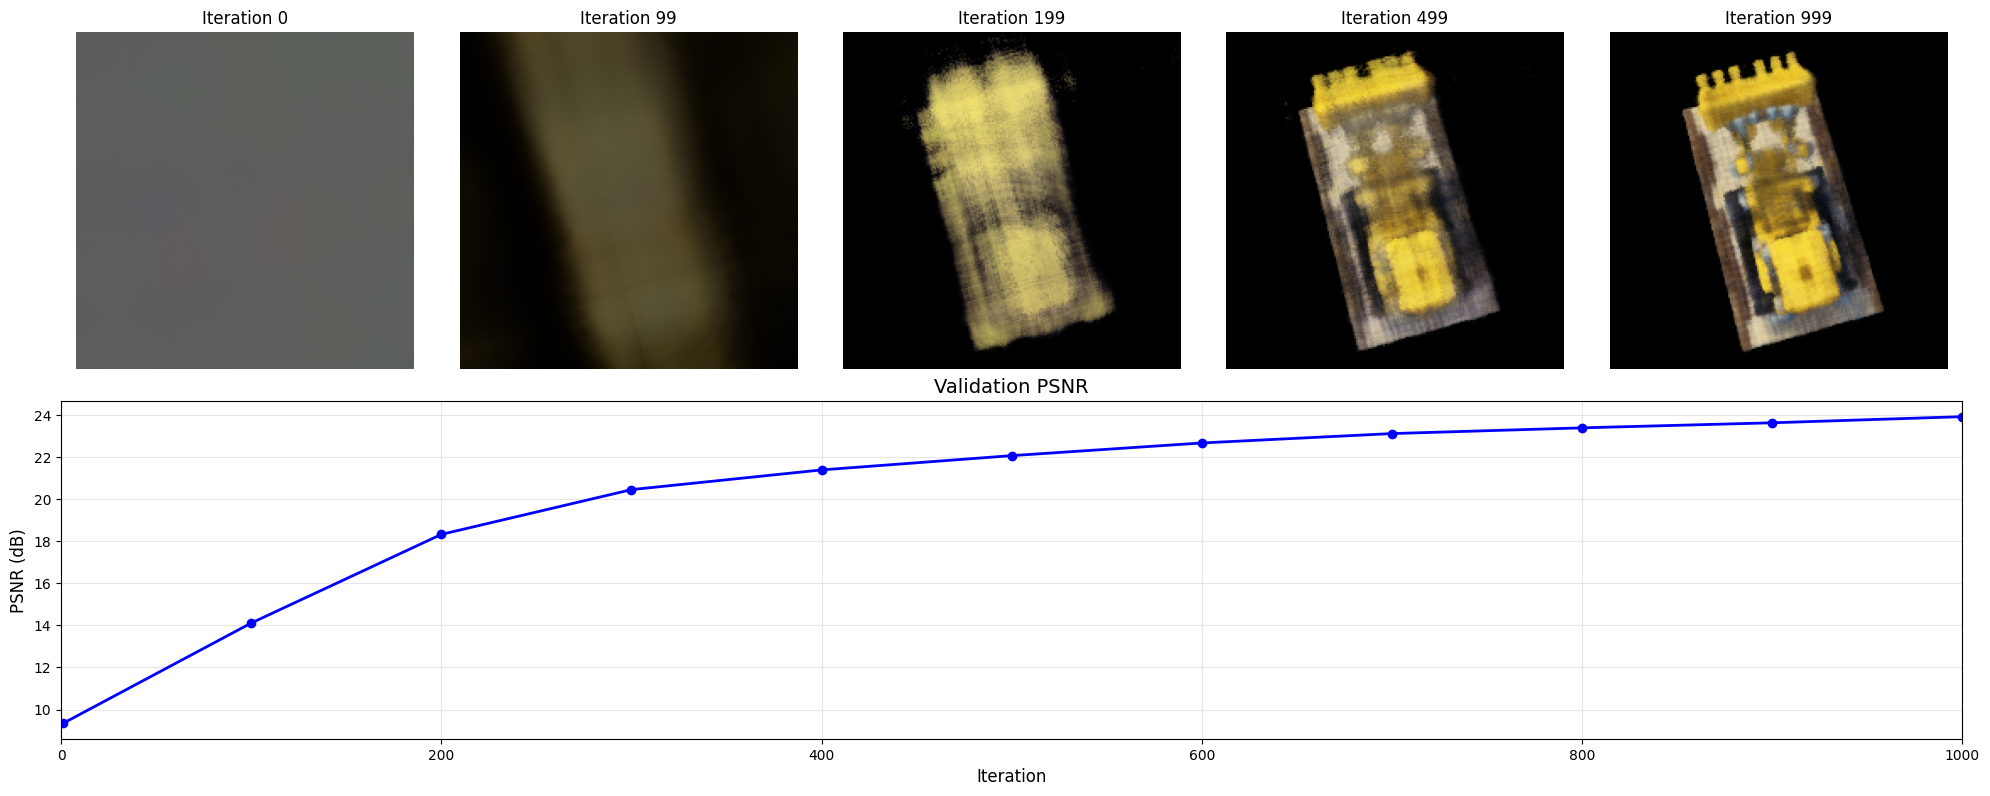

In [33]:
plot_training_progress(rendered_images, val_psnrs, [0, 100, 200, 500, 1000])

In [ ]:
def render_novel_views(model, c2ws_test, K, img_shape, n_samples, near, far, device):
    model.eval()
    rendered_views = []
    if isinstance(c2ws_test, np.ndarray):
        c2ws_test = torch.from_numpy(c2ws_test).float().to(device)
    if isinstance(K, np.ndarray):
        K = torch.from_numpy(K).float().to(device)
        
    with torch.no_grad():
        for i in tqdm(range(len(c2ws_test)), desc="Rendering views"):
            rendered_img = render_image(model, c2ws_test[i], K, img_shape, n_samples, near, far, device)
            rendered_views.append(rendered_img.cpu())
    
    return rendered_views

In [ ]:
def create_video(images, output_path='lego_novel_views.mp4', fps=30):    
    frames = []
    for img in images:
        if torch.is_tensor(img):
            img = img.cpu().numpy()
        img = np.clip(img, 0, 1)
        img = (img * 255).astype(np.uint8)
        frames.append(img)
    H, W = frames[0].shape[:2] 
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (W, H))
    for frame in frames:
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        out.write(frame_bgr)
    
    out.release()

In [ ]:
novel_views = render_novel_views(
    model, c2ws_test, K_tensor, 
    (H, W), n_samples=64, near=2.0, far=6.0, device=device
)

create_video(novel_views, output_path='lego_novel_views.mp4', fps=30)

Rendering 60 novel views...


Rendering views: 100%|██████████| 60/60 [02:15<00:00,  2.26s/it]

Video saved to lego_novel_views.mp4


In [67]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
data = np.load(f"dataset.npz")
images_train = data["images_train"] / 255.0
c2ws_train = data["c2ws_train"]
focal = data["focal"]
original_H, original_W = images_train.shape[1:3]
target_H, target_W = 450, 450
images_train = np.array([cv2.resize(img, (target_W, target_H)) for img in images_train])
scale_x = target_W / original_W
scale_y = target_H / original_H
K = np.array([
    [focal * scale_x, 0, target_W / 2],
    [0, focal * scale_y, target_H / 2],
    [0, 0, 1]
])
K_tensor = torch.from_numpy(K).float().to(device)

dataset = RaysData(images_train, K_tensor, c2ws_train, device=device)

model = NeuralRadianceField()
model, train_losses, train_psnrs, rendered_images = train_nerf(
    model, dataset, 
    n_iterations=10000,
    batch_size=5000,
    lr=1e-3,
    n_samples=64,
    device=device,
    near=0.011, far=0.436
)

Training NeRF:   0%|          | 0/10000 [00:15<?, ?it/s, loss=0.267614, train_psnr=5.72]


Iteration 1: Train PSNR = 5.72 dB


Training NeRF:   1%|          | 100/10000 [01:38<1:58:34,  1.39it/s, loss=0.092702, train_psnr=10.33]


Iteration 100: Train PSNR = 10.33 dB


Training NeRF:   2%|▏         | 199/10000 [02:56<1:59:09,  1.37it/s, loss=0.067407, train_psnr=11.71]


Iteration 200: Train PSNR = 11.71 dB


Training NeRF:   2%|▏         | 226/10000 [03:28<2:30:08,  1.09it/s, loss=0.067952, train_psnr=11.68] 


KeyboardInterrupt: 

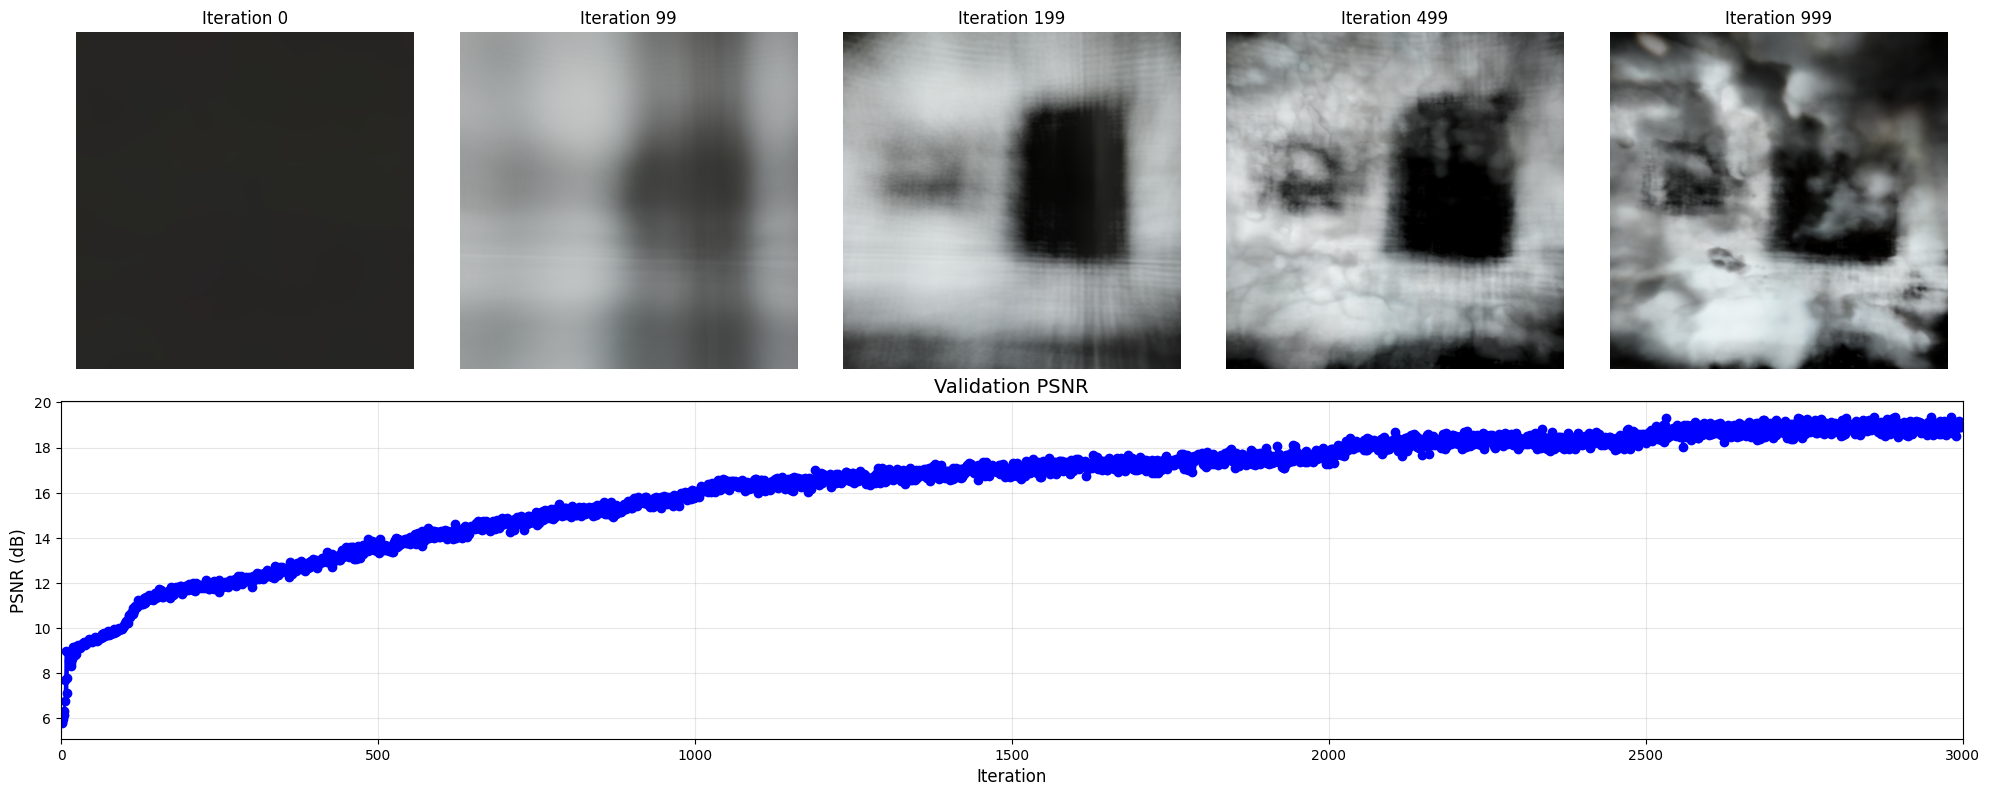

In [61]:
import matplotlib.pyplot as plt

plot_training_progress(rendered_images, train_psnrs, [0, 100, 200, 500, 1000])

In [63]:
# Render novel views
novel_views = render_novel_views(
    model, c2ws_train, K_tensor, 
    (H, W), n_samples=64, near=0.011, far=0.436, device=device
)

# Create video
create_video(novel_views, output_path='purse_novel_views_2.mp4', fps=30)

Rendering 27 novel views...


Rendering views:   0%|          | 0/27 [00:00<?, ?it/s]

Rendering views: 100%|██████████| 27/27 [05:06<00:00, 11.37s/it]

Video saved to purse_novel_views_2.mp4
